In [4]:
!pip install librosa resampy

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 67.6/67.6 kB 261.7 kB/s eta 0:00:00
   -------------------------------------- 357.3/357.3 kB 304.1 kB/s eta 0:00:00
   ---------------------------------------- 1.8/1.8 MB 183.6 kB/s eta 0:00:00
   ---------------------------------------- 46.2/46.2 kB 177.1 kB/s eta 0:00:00
   -------------------------------------- 245.4/245.4 kB 177.1 kB/s eta 0:00:00


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import py7zr
import librosa
import os

In [25]:
# Path to your .7z file
file_path = r'C:\Users\Hp\Documents\Semester 7\Computer Vision\samples.7z'

# Directory to extract the contents of the .7z file
extracted_dir = r'C:\Users\Hp\Documents\Semester 7\Computer Vision'

# Create the directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# Extract the contents of the .7z file
with py7zr.SevenZipFile(file_path, mode='r') as z:
    z.extractall(path=extracted_dir)

print("Extraction completed.")


Extraction completed.


In [39]:
def load_data(test_size=0.2, chunk_duration=1):
    x, y = [], []
    for file in os.listdir(r'C:\Users\Hp\Documents\Semester 7\Computer Vision\samples'):
        # Load audio file
        audio, sample_rate = librosa.load(r'C:\Users\Hp\Documents\Semester 7\Computer Vision\samples\\' + file, res_type='kaiser_fast')

        # Calculate number of chunks
        num_chunks = int(np.ceil(len(audio) / (sample_rate * chunk_duration)))

        # Extract features from each chunk
        for i in range(num_chunks):
            start = int(i * sample_rate * chunk_duration)
            end = min(len(audio), int((i + 1) * sample_rate * chunk_duration))
            chunk_audio = audio[start:end]

            # Extract features from audio chunk
            feature = extract_features_from_audio(chunk_audio, sample_rate)
            x.append(feature)

            # Extract class label from the file name
            class_label = file.split('(')[0]  # Assuming the class label is before the first '-'
            y.append(class_label)

    # Encode the labels
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)

    return train_test_split(np.array(x), y, test_size=test_size, random_state=42)


In [40]:
def extract_features_from_audio(audio, sample_rate, mfcc=True, chroma=True, mel=True, zero_crossing_rate=True, spectral_bandwidth=True, statistic='square_root_sum'):
    result = []

    if mfcc:
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40, n_fft=1024)
        if statistic == 'square_root_sum':
            mfccs = np.sqrt(np.sum(np.square(mfccs), axis=1))
        # Add other cases for different statistics if needed

        result.append(mfccs)

    if chroma:
        stft = np.abs(librosa.stft(audio, n_fft=1024))
        chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
        if statistic == 'square_root_sum':
            chroma = np.sqrt(np.sum(np.square(chroma), axis=1))
        # Add other cases for different statistics if needed

        result.append(chroma)

    if mel:
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=1024)
        if statistic == 'square_root_sum':
            mel = np.sqrt(np.sum(np.square(mel), axis=1))
        # Add other cases for different statistics if needed

        result.append(mel)

    if zero_crossing_rate:
        zcr = librosa.feature.zero_crossing_rate(audio)
        if statistic == 'square_root_sum':
            zcr = np.sqrt(np.sum(np.square(zcr), axis=1))
        # Add other cases for different statistics if needed

        result.append(zcr)

    if spectral_bandwidth:
        spec_bw = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate)
        if statistic == 'square_root_sum':
            spec_bw = np.sqrt(np.sum(np.square(spec_bw), axis=1))
        # Add other cases for different statistics if needed

        result.append(spec_bw)

    return np.hstack(result)


In [41]:
def create_model_with_dropout(input_shape, num_classes, dropout_rate=0.5):
    model = models.Sequential()
    model.add(layers.Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(256, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(256, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))  # Adding dropout layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

In [42]:
    # Load and split the dataset
X_train, X_test, y_train, y_test = load_data(test_size=0.2)


C:\Users\Hp\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1912
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=70
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=70
  warnings.warn(


In [43]:
# Update input_shape to have 2 dimensions (samples, time_steps)
input_shape = (X_train.shape[1], 1)
num_classes=4
# Create the model with dropout
model_with_dropout = create_model_with_dropout(input_shape=(X_train.shape[1], 1), num_classes=num_classes)

# Compile the model
model_with_dropout.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])
# Display model summary
model_with_dropout.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 180, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 90, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 88, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 44, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 42, 256)           98560     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 256)          0

In [44]:
# Train the model
model_with_dropout.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model_with_dropout.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/50
16/16 [==============================] - 5s 143ms/step - loss: 2.9873 - accuracy: 0.3220 - val_loss: 1.1143 - val_accuracy: 0.3730
Epoch 2/50
16/16 [==============================] - 2s 101ms/step - loss: 1.1605 - accuracy: 0.4640 - val_loss: 1.0176 - val_accuracy: 0.6349
Epoch 3/50
16/16 [==============================] - 2s 103ms/step - loss: 1.0451 - accuracy: 0.5500 - val_loss: 0.8907 - val_accuracy: 0.6349
Epoch 4/50
16/16 [==============================] - 2s 104ms/step - loss: 0.9248 - accuracy: 0.6400 - val_loss: 0.6542 - val_accuracy: 0.7857
Epoch 5/50
16/16 [==============================] - 3s 162ms/step - loss: 0.7935 - accuracy: 0.6980 - val_loss: 0.5469 - val_accuracy: 0.8651
Epoch 6/50
16/16 [==============================] - 3s 192ms/step - loss: 0.7821 - accuracy: 0.6920 - val_loss: 0.5398 - val_accuracy: 0.7778
Epoch 7/50
16/16 [==============================] - 2s 107ms/step - loss: 0.7501 - accuracy: 0.7060 - val_loss: 0.4774 - val_accuracy: 0.8016
Epoch 

In [54]:
# Obtain predictions from the trained model
y_pred_probabilities = model_with_dropout.predict(X_test)
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

4/4 [==============================] - 0s 26ms/step


In [55]:
# Calculate F1 score
f1 = f1_score(y_test, y_pred_labels, average='weighted')
print('F1 Score:', f1)


F1 Score: 0.9063612313612314


In [56]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)
print('Confusion Matrix:')
print(conf_matrix)


Confusion Matrix:
[[23  1  0  1]
 [ 0 33  0  4]
 [ 0  0 26  3]
 [ 2  1  0 32]]


In [57]:
# Display classification report
print('Classification Report:')
print(classification_report(y_test, y_pred_labels))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        25
           1       0.94      0.89      0.92        37
           2       1.00      0.90      0.95        29
           3       0.80      0.91      0.85        35

    accuracy                           0.90       126
   macro avg       0.92      0.91      0.91       126
weighted avg       0.91      0.90      0.91       126



In [60]:
# Obtain predicted probabilities for each class from the trained model
y_pred_logits = model_with_dropout.predict(X_test)
y_pred_proba = tf.nn.softmax(y_pred_logits).numpy()


4/4 [==============================] - 0s 34ms/step


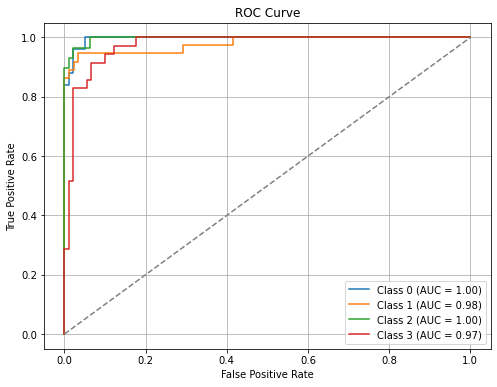

In [61]:
# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    if np.sum(y_test == i) > 0:  # Check if the class has positive samples
        fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

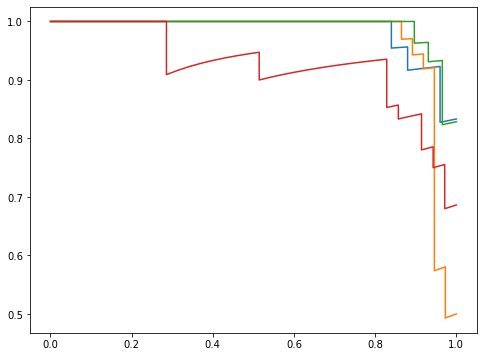

In [62]:
# Precision-Recall Curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_proba[:, i])
    average_precision = average_precision_score(y_test == i, y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {average_precision:.2f})')

No handles with labels found to put in legend.


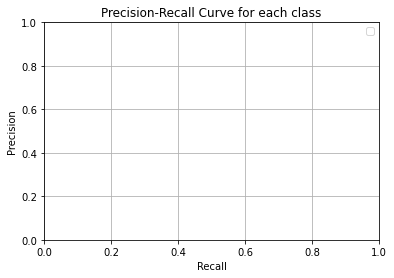

In [63]:
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each class')
plt.legend()
plt.grid(True)
plt.show()
